# Import

In [3]:
# 1. Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing and Feature Engineering
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# Models
import xgboost as xgb

# Advanced Models
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Hyperparameter Optimization
import optuna

# Interpretability
import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import joblib

# Datos


In [4]:
Independientes = pd.read_csv('../Datos/Procesados/Independientes.csv')
Conteo_Farms = pd.read_csv('../Datos/Procesados/FarmCantidad.csv')

merged_df = pd.merge(Independientes, Conteo_Farms, on=['Año Censal','Entidad','Municipio'])

farms_full = merged_df.dropna()
# farms_full = farms_full[farms_full['Año Censal'] == 2018]

In [5]:
for col in farms_full.columns:
  print(col)

Año Censal
Entidad
Municipio
Edad mediana
Grado promedio de escolaridad de la población de 15 y más años
Hogares censales
Población de 5 años y más que asiste a la escuela
Población derechohabiente a servicios de salud
Población en hogares censales
Población en hogares familiares
Población en hogares no familiares
Población total
Porcentaje de población de 15 a 29 años
Porcentaje de población de 60 y más años
Promedio de ocupantes en viviendas particulares habitadas
Tamaño promedio de los hogares censales
Total de viviendas particulares habitadas
Viviendas particulares habitadas
Viviendas particulares habitadas que disponen de agua de la red pública en el ámbito de la vivienda
Viviendas particulares habitadas que disponen de computadora
Viviendas particulares habitadas que disponen de drenaje
Viviendas particulares habitadas que disponen de energía eléctrica
Viviendas particulares habitadas que disponen de excusado o sanitario
Viviendas particulares habitadas que disponen de lavadora
U

In [6]:
ceros_por_columna = farms_full.apply(lambda x: x.value_counts().get(0, 0))

print("Cantidad de ceros por columna:")
print(ceros_por_columna.to_frame(name='Cantidad de Ceros'))

Cantidad de ceros por columna:
                                                    Cantidad de Ceros
Año Censal                                                          0
Entidad                                                           404
Municipio                                                          18
Edad mediana                                                        0
Grado promedio de escolaridad de la población d...                  0
Hogares censales                                                    0
Población de 5 años y más que asiste a la escuela                   0
Población derechohabiente a servicios de salud                      0
Población en hogares censales                                       0
Población en hogares familiares                                     0
Población en hogares no familiares                                  0
Población total                                                     0
Porcentaje de población de 15 a 29 años                    

In [7]:
unique_entidades = farms_full['Entidad'].nunique()
print(f"Número de entidades únicas: {unique_entidades}")

entidad_counts = farms_full['Entidad'].value_counts()
print("Cantidad de datos por Entidad:")
print(entidad_counts)


Número de entidades únicas: 32
Cantidad de datos por Entidad:
Entidad
veracruz de ignacio de la llave    404
mexico                             359
puebla                             341
jalisco                            334
michoacan de ocampo                302
chiapas                            253
oaxaca                             251
hidalgo                            181
guerrero                           179
guanajuato                         158
zacatecas                          117
tlaxcala                           114
san luis potosi                    114
nuevo leon                          91
sonora                              90
morelos                             88
tamaulipas                          87
chihuahua                           84
yucatan                             77
coahuila de zaragoza                76
durango                             66
sinaloa                             65
ciudad de mexico                    64
tabasco                          

In [8]:
farms_full['Economic_Units_Per_Capita'] = farms_full['UE Unidades económicas'] / (farms_full['Población total'])
farms_full['Health_Units_Per_Capita'] = farms_full['UE Sector 62 Servicios de salud y de asistencia social'] / (farms_full['Población total'])
farms_full['Ingresos_Farmacia'] = farms_full['Total_Ingresos_Millones'] / farms_full['farms']

In [9]:
top_farms = pd.read_csv('../Datos/Resultados/TopFarmacias.csv')

In [10]:
top_farms_locations = list(zip(top_farms['Entidad'], top_farms['Municipio']))
farms_top_locations = farms_full[farms_full[['Entidad', 'Municipio']].apply(tuple, axis=1).isin(top_farms_locations)]

In [11]:
farms_top_locations

,Año Censal,Entidad,Municipio,Edad mediana,Grado promedio de escolaridad de la población de 15 y más años,Hogares censales,Población de 5 años y más que asiste a la escuela,Población derechohabiente a servicios de salud,Población en hogares censales,Población en hogares familiares,...,UE Subsector 623 Residencias de asistencia social y para el cuidado de la salud,total_area,Prod_Bruta_Per_Capita,%_Pob_Derechohabiente,Densidad_Poblacional,farms,Total_Ingresos_Millones,Economic_Units_Per_Capita,Health_Units_Per_Capita,Ingresos_Farmacia
0,2003,aguascalientes,aguascalientes,23.2,9.060000,163227.6,204878.6,471755.4,680701.6,668204.4,...,8.0,1.166359e+09,6691.164875,68.252301,0.592608,263.0,754.479,0.017247,0.001749,2.868741
1,2008,aguascalientes,aguascalientes,24.6,9.606000,190221.8,224559.4,574924.8,758534.0,740727.2,...,12.0,1.166359e+09,7812.850849,74.916265,0.657965,307.0,1342.622,0.017421,0.002249,4.373362
2,2013,aguascalientes,aguascalientes,25.9,10.118202,220783.1,238060.5,662516.3,837610.5,811816.5,...,26.0,1.166359e+09,10048.067657,78.627244,0.722422,303.0,1602.102,0.017096,0.002516,5.287465
3,2018,aguascalientes,aguascalientes,27.4,10.631872,253636.6,249533.0,742406.8,914678.0,879284.0,...,33.0,1.166359e+09,19854.792215,80.819905,0.787574,330.0,2298.195,0.016698,0.002682,6.964227
4,2003,aguascalientes,asientos,19.2,6.420000,8324.8,11360.6,23247.0,39240.6,38817.8,...,1.0,5.433743e+08,463.388904,58.952563,0.072571,5.0,0.945,0.005706,0.000228,0.189000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,2013,zacatecas,ojocaliente,22.9,7.761783,9853.0,12025.3,30906.2,41612.9,40853.4,...,0.0,6.379904e+08,3971.533385,74.006973,0.065457,11.0,11.003,0.014798,0.001485,1.000273
4142,2018,zacatecas,ojocaliente,24.4,8.331422,10593.0,11870.8,33568.2,43379.4,42422.4,...,0.0,6.379904e+08,7154.282243,77.233614,0.068125,13.0,7.323,0.015530,0.001634,0.563308
4173,2008,zacatecas,villa garcia,22.6,7.580000,4024.8,5242.6,10335.2,17553.0,17311.8,...,0.0,3.382305e+08,665.513671,58.798230,0.051969,3.0,0.497,0.011151,0.000853,0.165667
4174,2013,zacatecas,villa garcia,23.9,8.286387,4437.6,5437.6,13808.6,18626.2,18324.3,...,0.0,3.382305e+08,694.901801,74.057428,0.055127,5.0,1.355,0.010619,0.000483,0.271000


In [12]:
unique_entidades = farms_top_locations['Entidad'].nunique()
print(f"Número de entidades únicas: {unique_entidades}")

entidad_counts = farms_top_locations['Entidad'].value_counts()
print("Cantidad de datos por Entidad:")
print(entidad_counts)

Número de entidades únicas: 31
Cantidad de datos por Entidad:
Entidad
mexico                             155
veracruz de ignacio de la llave    154
jalisco                             91
puebla                              88
guerrero                            70
chiapas                             66
michoacan de ocampo                 57
tamaulipas                          57
hidalgo                             56
ciudad de mexico                    56
san luis potosi                     47
oaxaca                              47
tabasco                             44
nuevo leon                          37
yucatan                             35
sinaloa                             32
morelos                             31
sonora                              31
zacatecas                           26
chihuahua                           24
coahuila de zaragoza                21
queretaro                           20
baja california                     20
quintana roo                     

In [13]:
farms_full = farms_top_locations

### Limpiar indicadores

In [14]:
columns_to_drop = [
                   'Porcentaje de población de 15 a 29 años',
                   'Grado promedio de escolaridad de la población de 15 y más años',
                   "Población de 5 años y más que asiste a la escuela"
                   ]

farms_full = farms_full.drop(columns=columns_to_drop)


In [15]:
key_cols = ['Municipio', 'Entidad']
for col in farms_full.columns:
  if col not in key_cols:
    try:
      farms_full[col] = farms_full[col].astype(float)
    except ValueError:
      print(f"Column '{col}' cannot be converted to float.")

In [16]:
key_cols = ['Año Censal', 'Municipio', 'Entidad']
pharma_cols = ['farms', 'Total_Ingresos_Millones', 'Ingresos_Farmacia']

test_cols = [col for col in farms_full.columns if col not in key_cols + pharma_cols]

In [18]:
features = test_cols
target = 'farms'

try with cuanto generan

# Entrenamiento

## Preprocesamiento

In [19]:
X = farms_full[features].copy()
y = farms_full[target].copy()

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

skewed_features = X_imputed.skew().sort_values(ascending=False)
skewness_threshold = 0.75
high_skew = skewed_features[skewed_features > skewness_threshold].index
for feature in high_skew:
    X_imputed[feature] = np.log1p(X_imputed[feature])

X_fe = X_imputed.copy()

zero_pop = X_fe['Población total'] == 0
if zero_pop.any():
    print("Warning: Zero values found in 'Total_Population'. Adding small constant to avoid division by zero.")
    X_fe.loc[zero_pop, 'Población total'] += 1e-6

if np.isinf(X_fe.values).any():
    print("Warning: Infinite values found in the dataset.")
if np.isnan(X_fe.values).any():
    print("Warning: NaN values found in the dataset.")

X_fe.replace([np.inf, -np.inf], np.nan, inplace=True)
X_fe.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_fe), columns=X_fe.columns)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(X_scaled)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

joblib.dump(imputer, '../Datos/Resultados/Modelos/Preprocessing/imputer.pkl')
joblib.dump(scaler, '../Datos/Resultados/Modelos/Preprocessing/scaler.pkl')

with open('../Datos/Resultados/Modelos/Preprocessing/skewed_features.pkl', 'wb') as f:
    joblib.dump(high_skew.tolist(), f)

with open('../Datos/Resultados/Modelos/Preprocessing/features.pkl', 'wb') as f:
    joblib.dump(X_fe.columns.tolist(), f)


## Entrenar

In [21]:
# XGBoost Model with Hyperparameter Optimization using Optuna
def xgb_objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }
    xgb_model = xgb.XGBRegressor(**param)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    preds = xgb_model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

xgb_study = optuna.create_study(direction='minimize')


xgb_study.optimize(xgb_objective, n_trials=30, timeout=3600)
print('XGBoost Best Trial:', xgb_study.best_trial.params)

[I 2024-09-30 00:09:14,719] A new study created in memory with name: no-name-59e6d047-be08-4e2e-be81-2814e46490b5
[I 2024-09-30 00:09:19,236] Trial 0 finished with value: 24.49001993430329 and parameters: {'lambda': 0.32571918529743554, 'alpha': 0.0010842526063649144, 'colsample_bytree': 0.8881616989940169, 'subsample': 0.6974920917237086, 'learning_rate': 0.0046646945286034705, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 0 with value: 24.49001993430329.
[I 2024-09-30 00:09:21,219] Trial 1 finished with value: 23.87951009107373 and parameters: {'lambda': 0.024374457245879624, 'alpha': 1.0835028266436233, 'colsample_bytree': 0.9048799575761695, 'subsample': 0.5628235405581962, 'learning_rate': 0.026231120500233684, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 1 with value: 23.87951009107373.
[I 2024-09-30 00:09:25,442] Trial 2 finished with value: 80.41671893768206 and parameters: {'lambda': 0.0024360854082560307, 'alpha': 0.058147471392757666, 'colsample_bytree': 0.8

XGBoost Best Trial: {'lambda': 0.014950730475901057, 'alpha': 0.023947358944147654, 'colsample_bytree': 0.9033869095160502, 'subsample': 0.8854953856625528, 'learning_rate': 0.005289089219297902, 'max_depth': 9, 'min_child_weight': 3}


In [22]:
# Train the optimized XGBoost model
xgb_best_params = xgb_study.best_trial.params
xgb_best_params['tree_method'] = 'gpu_hist'
xgb_best_params['gpu_id'] = 0
xgb_best_params['n_estimators'] = 5000
xgb_best_params['objective'] = 'reg:squarederror'
xgb_best_params['random_state'] = 42

xgb_model = xgb.XGBRegressor(**xgb_best_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)


[0]	validation_0-rmse:129.31788
[1]	validation_0-rmse:128.63095
[2]	validation_0-rmse:128.00565
[3]	validation_0-rmse:127.39501
[4]	validation_0-rmse:126.70940
[5]	validation_0-rmse:126.07589
[6]	validation_0-rmse:125.45909
[7]	validation_0-rmse:124.84188
[8]	validation_0-rmse:124.22899
[9]	validation_0-rmse:123.64890
[10]	validation_0-rmse:122.97291
[11]	validation_0-rmse:122.30966
[12]	validation_0-rmse:121.68621
[13]	validation_0-rmse:121.00003
[14]	validation_0-rmse:120.33854
[15]	validation_0-rmse:119.71490
[16]	validation_0-rmse:119.07232
[17]	validation_0-rmse:118.45919
[18]	validation_0-rmse:117.85242
[19]	validation_0-rmse:117.21413
[20]	validation_0-rmse:116.63588
[21]	validation_0-rmse:116.04787
[22]	validation_0-rmse:115.45834
[23]	validation_0-rmse:114.87478
[24]	validation_0-rmse:114.29041
[25]	validation_0-rmse:113.71028
[26]	validation_0-rmse:113.09033
[27]	validation_0-rmse:112.48542
[28]	validation_0-rmse:111.91600
[29]	validation_0-rmse:111.31035
[30]	validation_0-rm

XGBRegressor(alpha=0.023947358944147654, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9033869095160502, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.014950730475901057,
             learning_rate=0.005289089219297902, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, ...)

## Resultados

In [23]:
xgb_pred = xgb_model.predict(X_test)

# b. Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2 Score: {r2:.4f}\n")

evaluate_model(y_test, xgb_pred, "XGBoost")

XGBoost Performance:
RMSE: 23.2862
R^2 Score: 0.9677



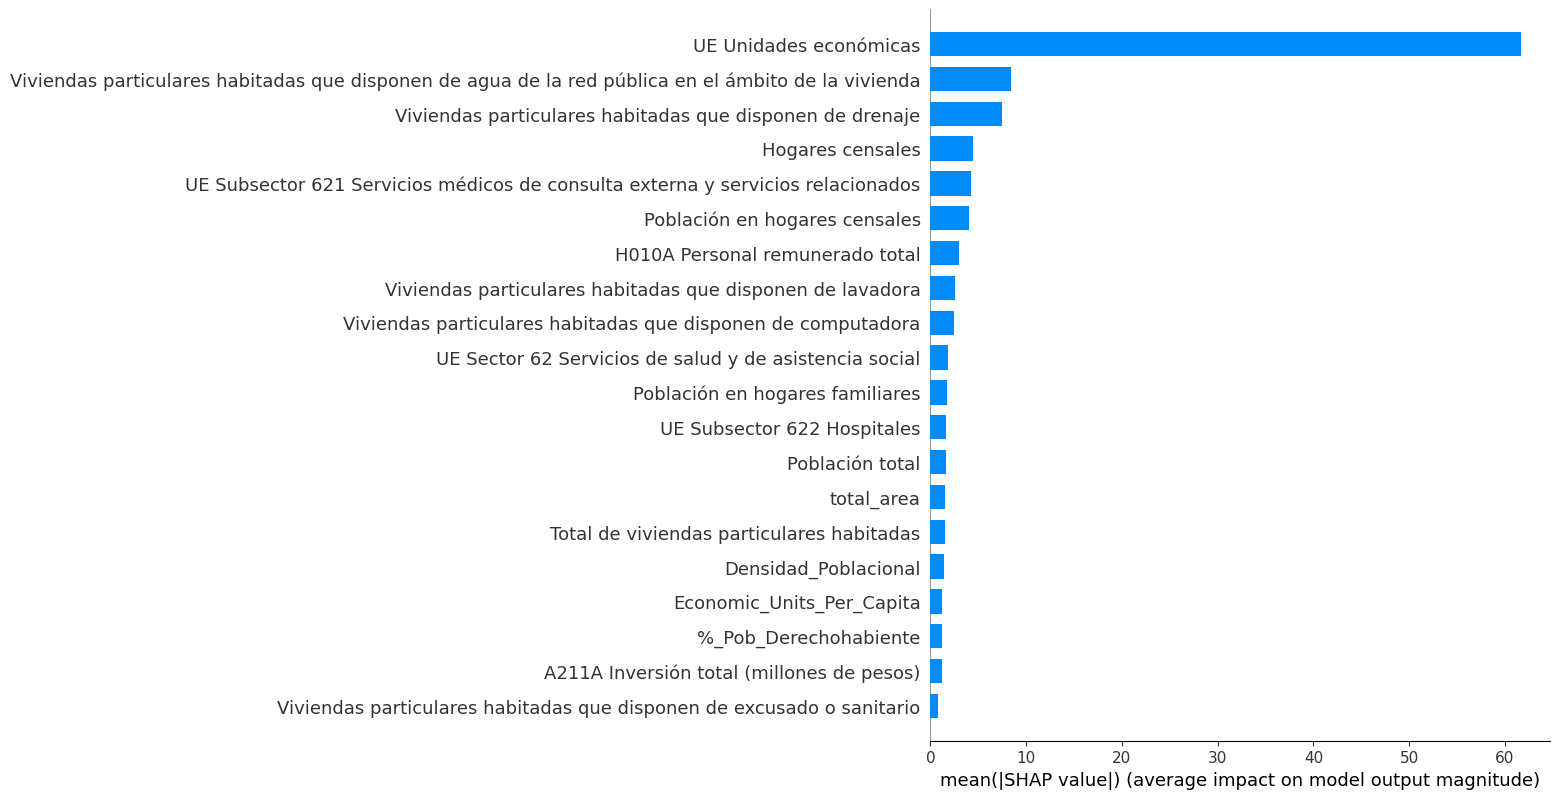

In [24]:
# For XGBoost
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X_test)

# Summary plot
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

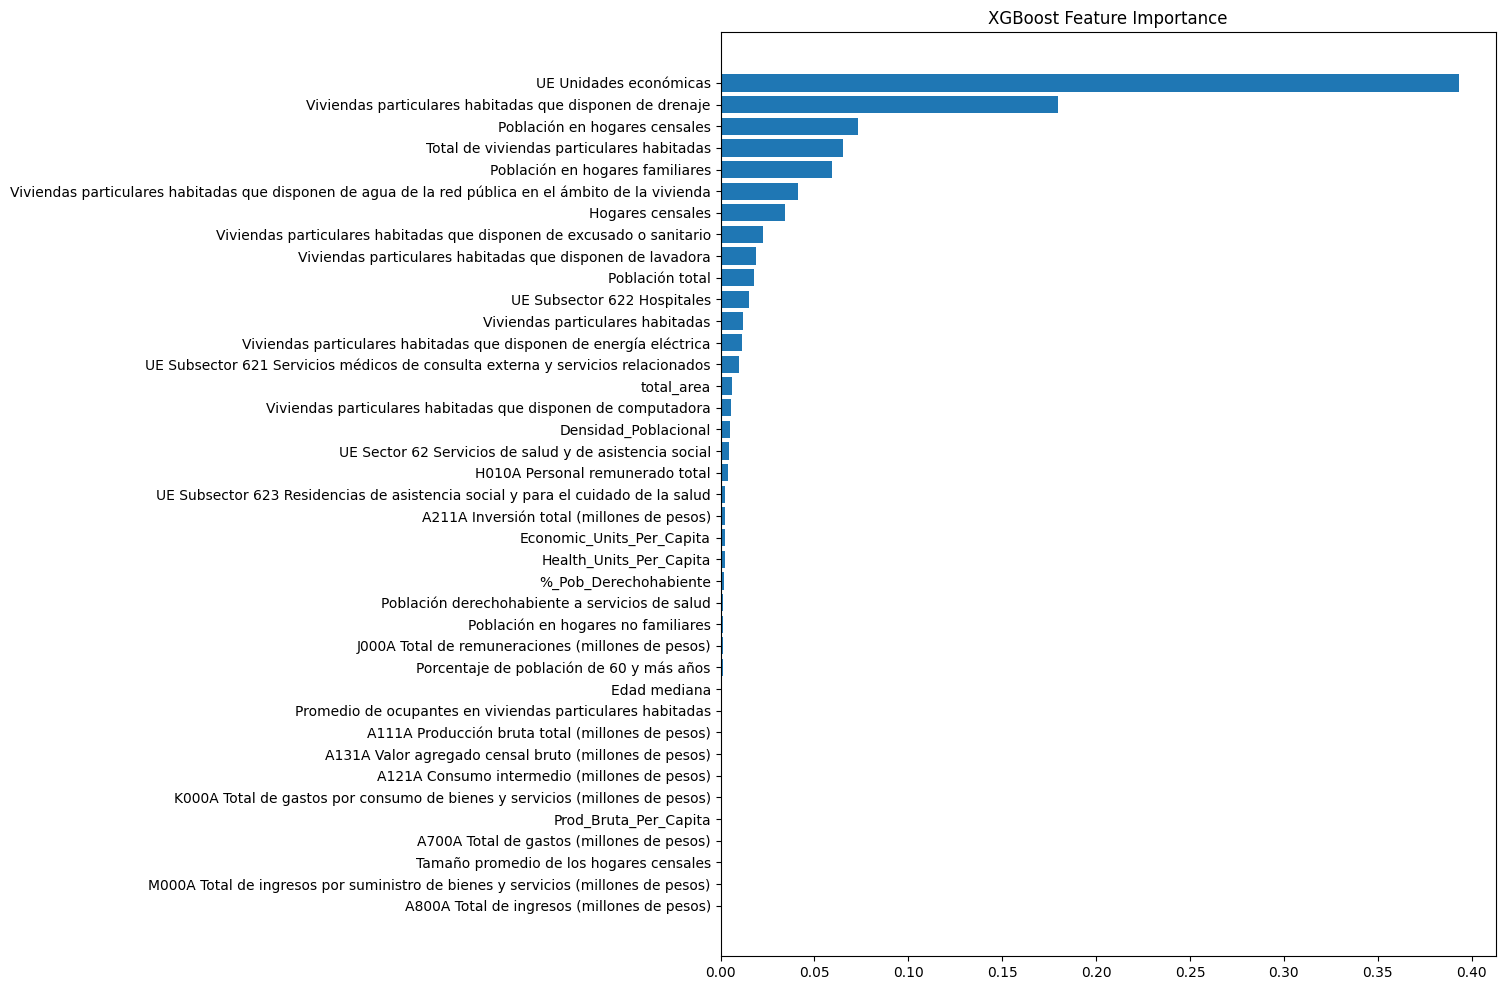

In [25]:
xgb_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(xgb_importance)
plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), xgb_importance[sorted_idx], align='center')
# Get the original feature names from the DataFrame 'farms_full' using the 'features' list
plt.yticks(range(len(sorted_idx)), [farms_full[features].columns[i] for i in sorted_idx])
plt.title('XGBoost Feature Importance')
plt.show()

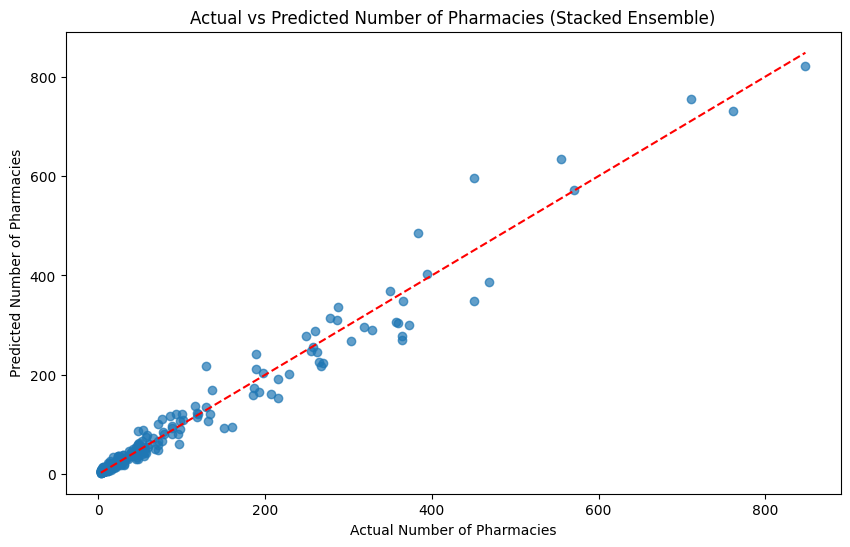

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Number of Pharmacies')
plt.ylabel('Predicted Number of Pharmacies')
plt.title('Actual vs Predicted Number of Pharmacies (Stacked Ensemble)')
plt.show()

## Exportar

In [27]:
joblib.dump(xgb_model, '../Datos/Resultados/Modelos/xgb_model.pkl')

['/content/drive/MyDrive/Dataton/Datos/Resultados/Modelos/xgb_model.pkl']